In [1]:
import numpy as np
from timeit import default_timer as timer

from joblib import Parallel, delayed

import multiprocessing

num_cores = multiprocessing.cpu_count()

from functools import reduce

import pickle

import pandas as pd

import matplotlib as plt


### Data downloading

In [2]:
D=np.load("X.npy")

D.shape

In [4]:
print(D.dtype.names)


None


In [419]:
cnt=0

for r in range(D.shape[0]):
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            cnt+=1
                
                
            
            
        

In [420]:
cnt

553430

### Sequential code for object-attribute bicluster generation

start = timer()

Objects={}
Attributes={}
idx=0

for r in range(D.shape[0]):
    Cols=[]
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            Cols.append(c)
    #if r%1000==0: print(r)

    Objects[r]=Cols
    
end = timer()
print("Object primes", end - start) # Time in seconds, e.g. 5.38091952400282        

start = timer()

for c in range(D.shape[1]):
    Rows=[]
    for r in range(D.shape[0]):
        if D[r][c]==-1:
            Rows.append(r)
    #if c%1000==0: print(c)
            
    Attributes[c]=Rows
    
end = timer()
print("Attribute primes", end - start)

start = timer()
    
for r in range(D.shape[0]):
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            if [Attributes[c],Objects[r]] not in B.values():
                B[(r,c)]=(Attributes[c], Objects[r])
                idx=idx+1
                #if idx%1000==0: print(idx)
            #B[(r,c)]=(Attributes[r], Objects[c])
            #idx=idx+1
            #if idx%1000==0: print(idx)

end = timer()
print("Pairing phase", end - start)       
   

### Paralle code for object-attribute bicluster generation

In [21]:
B={}
Objects={}
Attributes={}
idx=0



def objPrime(r,D):
    Cols=[]
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            Cols.append(c)
    if r%1000==0: print(r)

    return Cols


       


start = timer()            

    
def attrPrime(c,D):    
    Rows=[]
    for r in range(D.shape[0]):
        if D[r][c]==-1:
            Rows.append(r)
    if c%1000==0: print(c)
            
    return Rows




start = timer()

Objects = Parallel(n_jobs=num_cores)(delayed(objPrime)(r,D) for r in range(D.shape[0]))

end = timer()
print("Object primes", end - start) # Time in seconds, e.g. 5.38091952400282 

start = timer()    

#Objects = Parallel(n_jobs=num_cores/2)(delayed(objPrime)(r,D) for r in list(range(D.shape[0])))



Attributes = Parallel(n_jobs=num_cores)(delayed(attrPrime)(c,D) for c in range(D.shape[1]))

end = timer()
print("Attribute primes", end - start)

start = timer()

 
def biclGen(r,D,Objects,Attributes):
    idx=0
    B={}
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            
             if [Attributes[c],Objects[r]] not in B.values():
                B[(r,c)]=[Attributes[c], Objects[r]]
                idx=idx+1
                if idx%1000==0: print(idx)
            #B[(r,c)]=(Attributes[r], Objects[c])
            #idx=idx+1
            #if idx%1000==0: print(idx)
    return B
            
                

    
Bicl = Parallel(n_jobs=num_cores)(delayed(biclGen)(r,D, Objects, Attributes) for r in range(D.shape[0]))


end = timer()
print("Pairing phase", end - start)    



Object primes 155.13398409599995
Attribute primes 109.33147086999998
Pairing phase 3433.203342215


In [25]:
start = timer()

B = reduce((lambda x, y: {**x, **y}), Bicl)

end = timer()
print("Reduce", end - start)  

Reduce 31.883283216000564


In [348]:
len(Bicl)

NameError: name 'Bicl' is not defined

In [349]:
len(B)



383733

In [8]:
def Density(D,b):
    num=0
    for i in b[0]:
        for j in b[1]:
            if D[i][j]==-1:
                num=num+1
    return num/(len(b[0])*len(b[1]))

In [9]:
Density(D,B[(0,0)])

0.9835927375215471

In [16]:
len(B)

383733

### Computation of basic statistics 

In [10]:
def biclDenLen(D,Bk,key):
    den={}
    den[key]=(Density(D,Bk), len(Bk[0]),len(Bk[1]))
    if key[0]%10==0: print(key)
    return den
           
keys=B.keys()

import os
from joblib import dump, load

folder = './joblib_memmap2'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

data_filename_memmap = os.path.join(folder, 'data_memmap')
dict_filename_memmap = os.path.join(folder, 'dict_memmap')

dump(D, data_filename_memmap)
dump(B, dict_filename_memmap)
D = load(data_filename_memmap, mmap_mode='r')
B = load(dict_filename_memmap, mmap_mode='r')
                
start = timer()
    
#Bdl = Parallel(n_jobs=num_cores, backend="threading", verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D,B[key],key) for key in keys)
Bdl = Parallel(n_jobs=num_cores, verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D,B[key],key) for key in keys)



end = timer()
print("Density calculation phase", end - start) 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done 100 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 200 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 400 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 500 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 600 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 700 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 800 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 900 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1000 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1100 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1200 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1300 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 1400 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 1500 tasks      | elap

[Parallel(n_jobs=12)]: Done 13000 tasks      | elapsed: 33.0min
[Parallel(n_jobs=12)]: Done 13100 tasks      | elapsed: 33.1min
[Parallel(n_jobs=12)]: Done 13200 tasks      | elapsed: 33.1min
[Parallel(n_jobs=12)]: Done 13300 tasks      | elapsed: 34.9min
[Parallel(n_jobs=12)]: Done 13400 tasks      | elapsed: 35.3min
[Parallel(n_jobs=12)]: Done 13500 tasks      | elapsed: 35.3min
[Parallel(n_jobs=12)]: Done 13600 tasks      | elapsed: 35.4min
[Parallel(n_jobs=12)]: Done 13700 tasks      | elapsed: 35.6min
[Parallel(n_jobs=12)]: Done 13800 tasks      | elapsed: 35.7min
[Parallel(n_jobs=12)]: Done 13900 tasks      | elapsed: 35.8min
[Parallel(n_jobs=12)]: Done 14000 tasks      | elapsed: 35.8min
[Parallel(n_jobs=12)]: Done 14100 tasks      | elapsed: 35.9min
[Parallel(n_jobs=12)]: Done 14200 tasks      | elapsed: 36.0min
[Parallel(n_jobs=12)]: Done 14300 tasks      | elapsed: 36.0min
[Parallel(n_jobs=12)]: Done 14400 tasks      | elapsed: 36.2min
[Parallel(n_jobs=12)]: Done 14500 tasks 

[Parallel(n_jobs=12)]: Done 25900 tasks      | elapsed: 66.0min
[Parallel(n_jobs=12)]: Done 26000 tasks      | elapsed: 66.1min
[Parallel(n_jobs=12)]: Done 26100 tasks      | elapsed: 66.2min
[Parallel(n_jobs=12)]: Done 26200 tasks      | elapsed: 66.3min
[Parallel(n_jobs=12)]: Done 26300 tasks      | elapsed: 66.4min
[Parallel(n_jobs=12)]: Done 26400 tasks      | elapsed: 66.7min
[Parallel(n_jobs=12)]: Done 26500 tasks      | elapsed: 67.6min
[Parallel(n_jobs=12)]: Done 26600 tasks      | elapsed: 67.9min
[Parallel(n_jobs=12)]: Done 26700 tasks      | elapsed: 68.3min
[Parallel(n_jobs=12)]: Done 26800 tasks      | elapsed: 68.4min
[Parallel(n_jobs=12)]: Done 26900 tasks      | elapsed: 68.8min
[Parallel(n_jobs=12)]: Done 27000 tasks      | elapsed: 68.9min
[Parallel(n_jobs=12)]: Done 27100 tasks      | elapsed: 69.0min
[Parallel(n_jobs=12)]: Done 27200 tasks      | elapsed: 69.1min
[Parallel(n_jobs=12)]: Done 27300 tasks      | elapsed: 69.2min
[Parallel(n_jobs=12)]: Done 27400 tasks 

[Parallel(n_jobs=12)]: Done 38800 tasks      | elapsed: 98.6min
[Parallel(n_jobs=12)]: Done 38900 tasks      | elapsed: 99.2min
[Parallel(n_jobs=12)]: Done 39000 tasks      | elapsed: 99.2min
[Parallel(n_jobs=12)]: Done 39100 tasks      | elapsed: 99.4min
[Parallel(n_jobs=12)]: Done 39200 tasks      | elapsed: 99.5min
[Parallel(n_jobs=12)]: Done 39300 tasks      | elapsed: 99.6min
[Parallel(n_jobs=12)]: Done 39400 tasks      | elapsed: 99.7min
[Parallel(n_jobs=12)]: Done 39500 tasks      | elapsed: 99.9min
[Parallel(n_jobs=12)]: Done 39600 tasks      | elapsed: 100.3min
[Parallel(n_jobs=12)]: Done 39700 tasks      | elapsed: 100.4min
[Parallel(n_jobs=12)]: Done 39800 tasks      | elapsed: 100.7min
[Parallel(n_jobs=12)]: Done 39900 tasks      | elapsed: 101.4min
[Parallel(n_jobs=12)]: Done 40000 tasks      | elapsed: 101.6min
[Parallel(n_jobs=12)]: Done 40100 tasks      | elapsed: 102.2min
[Parallel(n_jobs=12)]: Done 40200 tasks      | elapsed: 102.3min
[Parallel(n_jobs=12)]: Done 40300

[Parallel(n_jobs=12)]: Done 51500 tasks      | elapsed: 130.1min
[Parallel(n_jobs=12)]: Done 51600 tasks      | elapsed: 130.3min
[Parallel(n_jobs=12)]: Done 51700 tasks      | elapsed: 130.3min
[Parallel(n_jobs=12)]: Done 51800 tasks      | elapsed: 130.9min
[Parallel(n_jobs=12)]: Done 51900 tasks      | elapsed: 131.2min
[Parallel(n_jobs=12)]: Done 52000 tasks      | elapsed: 131.3min
[Parallel(n_jobs=12)]: Done 52100 tasks      | elapsed: 132.4min
[Parallel(n_jobs=12)]: Done 52200 tasks      | elapsed: 132.6min
[Parallel(n_jobs=12)]: Done 52300 tasks      | elapsed: 132.6min
[Parallel(n_jobs=12)]: Done 52400 tasks      | elapsed: 132.7min
[Parallel(n_jobs=12)]: Done 52500 tasks      | elapsed: 132.9min
[Parallel(n_jobs=12)]: Done 52600 tasks      | elapsed: 132.9min
[Parallel(n_jobs=12)]: Done 52700 tasks      | elapsed: 133.0min
[Parallel(n_jobs=12)]: Done 52800 tasks      | elapsed: 133.2min
[Parallel(n_jobs=12)]: Done 52900 tasks      | elapsed: 133.4min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 64200 tasks      | elapsed: 162.4min
[Parallel(n_jobs=12)]: Done 64300 tasks      | elapsed: 162.5min
[Parallel(n_jobs=12)]: Done 64400 tasks      | elapsed: 162.8min
[Parallel(n_jobs=12)]: Done 64500 tasks      | elapsed: 162.8min
[Parallel(n_jobs=12)]: Done 64600 tasks      | elapsed: 162.9min
[Parallel(n_jobs=12)]: Done 64700 tasks      | elapsed: 163.1min
[Parallel(n_jobs=12)]: Done 64800 tasks      | elapsed: 163.4min
[Parallel(n_jobs=12)]: Done 64900 tasks      | elapsed: 163.7min
[Parallel(n_jobs=12)]: Done 65000 tasks      | elapsed: 163.9min
[Parallel(n_jobs=12)]: Done 65100 tasks      | elapsed: 164.1min
[Parallel(n_jobs=12)]: Done 65200 tasks      | elapsed: 164.4min
[Parallel(n_jobs=12)]: Done 65300 tasks      | elapsed: 165.3min
[Parallel(n_jobs=12)]: Done 65400 tasks      | elapsed: 165.4min
[Parallel(n_jobs=12)]: Done 65500 tasks      | elapsed: 165.5min
[Parallel(n_jobs=12)]: Done 65600 tasks      | elapsed: 165.7min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 76900 tasks      | elapsed: 194.0min
[Parallel(n_jobs=12)]: Done 77000 tasks      | elapsed: 194.2min
[Parallel(n_jobs=12)]: Done 77100 tasks      | elapsed: 194.3min
[Parallel(n_jobs=12)]: Done 77200 tasks      | elapsed: 194.4min
[Parallel(n_jobs=12)]: Done 77300 tasks      | elapsed: 194.7min
[Parallel(n_jobs=12)]: Done 77400 tasks      | elapsed: 195.3min
[Parallel(n_jobs=12)]: Done 77500 tasks      | elapsed: 195.4min
[Parallel(n_jobs=12)]: Done 77600 tasks      | elapsed: 195.6min
[Parallel(n_jobs=12)]: Done 77700 tasks      | elapsed: 195.7min
[Parallel(n_jobs=12)]: Done 77800 tasks      | elapsed: 196.0min
[Parallel(n_jobs=12)]: Done 77900 tasks      | elapsed: 196.1min
[Parallel(n_jobs=12)]: Done 78000 tasks      | elapsed: 196.4min
[Parallel(n_jobs=12)]: Done 78100 tasks      | elapsed: 196.8min
[Parallel(n_jobs=12)]: Done 78200 tasks      | elapsed: 197.2min
[Parallel(n_jobs=12)]: Done 78300 tasks      | elapsed: 197.4min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 89600 tasks      | elapsed: 225.5min
[Parallel(n_jobs=12)]: Done 89700 tasks      | elapsed: 225.9min
[Parallel(n_jobs=12)]: Done 89800 tasks      | elapsed: 226.1min
[Parallel(n_jobs=12)]: Done 89900 tasks      | elapsed: 226.2min
[Parallel(n_jobs=12)]: Done 90000 tasks      | elapsed: 226.6min
[Parallel(n_jobs=12)]: Done 90100 tasks      | elapsed: 226.7min
[Parallel(n_jobs=12)]: Done 90200 tasks      | elapsed: 226.9min
[Parallel(n_jobs=12)]: Done 90300 tasks      | elapsed: 227.3min
[Parallel(n_jobs=12)]: Done 90400 tasks      | elapsed: 227.7min
[Parallel(n_jobs=12)]: Done 90500 tasks      | elapsed: 228.1min
[Parallel(n_jobs=12)]: Done 90600 tasks      | elapsed: 228.4min
[Parallel(n_jobs=12)]: Done 90700 tasks      | elapsed: 228.4min
[Parallel(n_jobs=12)]: Done 90800 tasks      | elapsed: 228.6min
[Parallel(n_jobs=12)]: Done 90900 tasks      | elapsed: 229.0min
[Parallel(n_jobs=12)]: Done 91000 tasks      | elapsed: 229.2min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 102200 tasks      | elapsed: 256.5min
[Parallel(n_jobs=12)]: Done 102300 tasks      | elapsed: 256.7min
[Parallel(n_jobs=12)]: Done 102400 tasks      | elapsed: 257.2min
[Parallel(n_jobs=12)]: Done 102500 tasks      | elapsed: 257.5min
[Parallel(n_jobs=12)]: Done 102600 tasks      | elapsed: 257.9min
[Parallel(n_jobs=12)]: Done 102700 tasks      | elapsed: 258.2min
[Parallel(n_jobs=12)]: Done 102800 tasks      | elapsed: 258.2min
[Parallel(n_jobs=12)]: Done 102900 tasks      | elapsed: 258.5min
[Parallel(n_jobs=12)]: Done 103000 tasks      | elapsed: 258.7min
[Parallel(n_jobs=12)]: Done 103100 tasks      | elapsed: 258.8min
[Parallel(n_jobs=12)]: Done 103200 tasks      | elapsed: 258.8min
[Parallel(n_jobs=12)]: Done 103300 tasks      | elapsed: 259.0min
[Parallel(n_jobs=12)]: Done 103400 tasks      | elapsed: 259.5min
[Parallel(n_jobs=12)]: Done 103500 tasks      | elapsed: 259.6min
[Parallel(n_jobs=12)]: Done 103600 tasks      | elapsed: 260.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 114700 tasks      | elapsed: 286.6min
[Parallel(n_jobs=12)]: Done 114800 tasks      | elapsed: 286.8min
[Parallel(n_jobs=12)]: Done 114900 tasks      | elapsed: 287.1min
[Parallel(n_jobs=12)]: Done 115000 tasks      | elapsed: 287.1min
[Parallel(n_jobs=12)]: Done 115100 tasks      | elapsed: 287.2min
[Parallel(n_jobs=12)]: Done 115200 tasks      | elapsed: 287.4min
[Parallel(n_jobs=12)]: Done 115300 tasks      | elapsed: 287.6min
[Parallel(n_jobs=12)]: Done 115400 tasks      | elapsed: 287.9min
[Parallel(n_jobs=12)]: Done 115500 tasks      | elapsed: 288.2min
[Parallel(n_jobs=12)]: Done 115600 tasks      | elapsed: 288.4min
[Parallel(n_jobs=12)]: Done 115700 tasks      | elapsed: 289.1min
[Parallel(n_jobs=12)]: Done 115800 tasks      | elapsed: 289.3min
[Parallel(n_jobs=12)]: Done 115900 tasks      | elapsed: 289.4min
[Parallel(n_jobs=12)]: Done 116000 tasks      | elapsed: 289.6min
[Parallel(n_jobs=12)]: Done 116100 tasks      | elapsed: 289.9min
[Parallel(

[Parallel(n_jobs=12)]: Done 127200 tasks      | elapsed: 306.3min
[Parallel(n_jobs=12)]: Done 127300 tasks      | elapsed: 306.4min
[Parallel(n_jobs=12)]: Done 127400 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127500 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127600 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127700 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127800 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127900 tasks      | elapsed: 306.8min
[Parallel(n_jobs=12)]: Done 128000 tasks      | elapsed: 307.0min
[Parallel(n_jobs=12)]: Done 128100 tasks      | elapsed: 307.1min
[Parallel(n_jobs=12)]: Done 128200 tasks      | elapsed: 307.3min
[Parallel(n_jobs=12)]: Done 128300 tasks      | elapsed: 307.3min
[Parallel(n_jobs=12)]: Done 128400 tasks      | elapsed: 307.5min
[Parallel(n_jobs=12)]: Done 128500 tasks      | elapsed: 307.6min
[Parallel(n_jobs=12)]: Done 128600 tasks      | elapsed: 307.7min
[Parallel(

[Parallel(n_jobs=12)]: Done 139700 tasks      | elapsed: 319.1min
[Parallel(n_jobs=12)]: Done 139800 tasks      | elapsed: 319.2min
[Parallel(n_jobs=12)]: Done 139900 tasks      | elapsed: 319.3min
[Parallel(n_jobs=12)]: Done 140000 tasks      | elapsed: 319.4min
[Parallel(n_jobs=12)]: Done 140100 tasks      | elapsed: 319.5min
[Parallel(n_jobs=12)]: Done 140200 tasks      | elapsed: 319.5min
[Parallel(n_jobs=12)]: Done 140300 tasks      | elapsed: 319.7min
[Parallel(n_jobs=12)]: Done 140400 tasks      | elapsed: 319.8min
[Parallel(n_jobs=12)]: Done 140500 tasks      | elapsed: 319.9min
[Parallel(n_jobs=12)]: Done 140600 tasks      | elapsed: 320.2min
[Parallel(n_jobs=12)]: Done 140700 tasks      | elapsed: 320.2min
[Parallel(n_jobs=12)]: Done 140800 tasks      | elapsed: 320.3min
[Parallel(n_jobs=12)]: Done 140900 tasks      | elapsed: 320.3min
[Parallel(n_jobs=12)]: Done 141000 tasks      | elapsed: 320.5min
[Parallel(n_jobs=12)]: Done 141100 tasks      | elapsed: 320.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 152200 tasks      | elapsed: 331.9min
[Parallel(n_jobs=12)]: Done 152300 tasks      | elapsed: 332.0min
[Parallel(n_jobs=12)]: Done 152400 tasks      | elapsed: 332.4min
[Parallel(n_jobs=12)]: Done 152500 tasks      | elapsed: 332.4min
[Parallel(n_jobs=12)]: Done 152600 tasks      | elapsed: 332.6min
[Parallel(n_jobs=12)]: Done 152700 tasks      | elapsed: 332.6min
[Parallel(n_jobs=12)]: Done 152800 tasks      | elapsed: 332.8min
[Parallel(n_jobs=12)]: Done 152900 tasks      | elapsed: 332.9min
[Parallel(n_jobs=12)]: Done 153000 tasks      | elapsed: 333.0min
[Parallel(n_jobs=12)]: Done 153100 tasks      | elapsed: 333.1min
[Parallel(n_jobs=12)]: Done 153200 tasks      | elapsed: 333.1min
[Parallel(n_jobs=12)]: Done 153300 tasks      | elapsed: 333.2min
[Parallel(n_jobs=12)]: Done 153400 tasks      | elapsed: 333.2min
[Parallel(n_jobs=12)]: Done 153500 tasks      | elapsed: 333.3min
[Parallel(n_jobs=12)]: Done 153600 tasks      | elapsed: 333.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 164700 tasks      | elapsed: 345.3min
[Parallel(n_jobs=12)]: Done 164800 tasks      | elapsed: 345.6min
[Parallel(n_jobs=12)]: Done 164900 tasks      | elapsed: 345.7min
[Parallel(n_jobs=12)]: Done 165000 tasks      | elapsed: 345.7min
[Parallel(n_jobs=12)]: Done 165100 tasks      | elapsed: 346.0min
[Parallel(n_jobs=12)]: Done 165200 tasks      | elapsed: 346.0min
[Parallel(n_jobs=12)]: Done 165300 tasks      | elapsed: 346.0min
[Parallel(n_jobs=12)]: Done 165400 tasks      | elapsed: 346.2min
[Parallel(n_jobs=12)]: Done 165500 tasks      | elapsed: 346.3min
[Parallel(n_jobs=12)]: Done 165600 tasks      | elapsed: 346.4min
[Parallel(n_jobs=12)]: Done 165700 tasks      | elapsed: 346.4min
[Parallel(n_jobs=12)]: Done 165800 tasks      | elapsed: 346.5min
[Parallel(n_jobs=12)]: Done 165900 tasks      | elapsed: 346.6min
[Parallel(n_jobs=12)]: Done 166000 tasks      | elapsed: 346.8min
[Parallel(n_jobs=12)]: Done 166100 tasks      | elapsed: 347.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 177200 tasks      | elapsed: 360.4min
[Parallel(n_jobs=12)]: Done 177300 tasks      | elapsed: 360.6min
[Parallel(n_jobs=12)]: Done 177400 tasks      | elapsed: 360.7min
[Parallel(n_jobs=12)]: Done 177500 tasks      | elapsed: 360.7min
[Parallel(n_jobs=12)]: Done 177600 tasks      | elapsed: 360.8min
[Parallel(n_jobs=12)]: Done 177700 tasks      | elapsed: 361.1min
[Parallel(n_jobs=12)]: Done 177800 tasks      | elapsed: 361.2min
[Parallel(n_jobs=12)]: Done 177900 tasks      | elapsed: 361.5min
[Parallel(n_jobs=12)]: Done 178000 tasks      | elapsed: 361.6min
[Parallel(n_jobs=12)]: Done 178100 tasks      | elapsed: 361.7min
[Parallel(n_jobs=12)]: Done 178200 tasks      | elapsed: 361.7min
[Parallel(n_jobs=12)]: Done 178300 tasks      | elapsed: 361.8min
[Parallel(n_jobs=12)]: Done 178400 tasks      | elapsed: 362.0min
[Parallel(n_jobs=12)]: Done 178500 tasks      | elapsed: 362.1min
[Parallel(n_jobs=12)]: Done 178600 tasks      | elapsed: 362.1min
[Parallel(

[Parallel(n_jobs=12)]: Done 189700 tasks      | elapsed: 369.5min
[Parallel(n_jobs=12)]: Done 189800 tasks      | elapsed: 369.5min
[Parallel(n_jobs=12)]: Done 189900 tasks      | elapsed: 369.5min
[Parallel(n_jobs=12)]: Done 190000 tasks      | elapsed: 369.6min
[Parallel(n_jobs=12)]: Done 190100 tasks      | elapsed: 369.6min
[Parallel(n_jobs=12)]: Done 190200 tasks      | elapsed: 369.8min
[Parallel(n_jobs=12)]: Done 190300 tasks      | elapsed: 369.8min
[Parallel(n_jobs=12)]: Done 190400 tasks      | elapsed: 369.8min
[Parallel(n_jobs=12)]: Done 190500 tasks      | elapsed: 369.9min
[Parallel(n_jobs=12)]: Done 190600 tasks      | elapsed: 369.9min
[Parallel(n_jobs=12)]: Done 190700 tasks      | elapsed: 370.0min
[Parallel(n_jobs=12)]: Done 190800 tasks      | elapsed: 370.1min
[Parallel(n_jobs=12)]: Done 190900 tasks      | elapsed: 370.1min
[Parallel(n_jobs=12)]: Done 191000 tasks      | elapsed: 370.1min
[Parallel(n_jobs=12)]: Done 191100 tasks      | elapsed: 370.1min
[Parallel(

[Parallel(n_jobs=12)]: Done 202300 tasks      | elapsed: 377.2min
[Parallel(n_jobs=12)]: Done 202400 tasks      | elapsed: 377.2min
[Parallel(n_jobs=12)]: Done 202500 tasks      | elapsed: 377.2min
[Parallel(n_jobs=12)]: Done 202600 tasks      | elapsed: 377.4min
[Parallel(n_jobs=12)]: Done 202700 tasks      | elapsed: 377.4min
[Parallel(n_jobs=12)]: Done 202800 tasks      | elapsed: 377.4min
[Parallel(n_jobs=12)]: Done 202900 tasks      | elapsed: 377.5min
[Parallel(n_jobs=12)]: Done 203000 tasks      | elapsed: 377.5min
[Parallel(n_jobs=12)]: Done 203100 tasks      | elapsed: 377.6min
[Parallel(n_jobs=12)]: Done 203200 tasks      | elapsed: 377.6min
[Parallel(n_jobs=12)]: Done 203300 tasks      | elapsed: 377.8min
[Parallel(n_jobs=12)]: Done 203400 tasks      | elapsed: 377.9min
[Parallel(n_jobs=12)]: Done 203500 tasks      | elapsed: 377.9min
[Parallel(n_jobs=12)]: Done 203600 tasks      | elapsed: 377.9min
[Parallel(n_jobs=12)]: Done 203700 tasks      | elapsed: 378.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 214800 tasks      | elapsed: 384.1min
[Parallel(n_jobs=12)]: Done 214900 tasks      | elapsed: 384.1min
[Parallel(n_jobs=12)]: Done 215000 tasks      | elapsed: 384.3min
[Parallel(n_jobs=12)]: Done 215100 tasks      | elapsed: 384.3min
[Parallel(n_jobs=12)]: Done 215200 tasks      | elapsed: 384.4min
[Parallel(n_jobs=12)]: Done 215300 tasks      | elapsed: 384.5min
[Parallel(n_jobs=12)]: Done 215400 tasks      | elapsed: 384.6min
[Parallel(n_jobs=12)]: Done 215500 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215600 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215700 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215800 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215900 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 216000 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 216100 tasks      | elapsed: 384.8min
[Parallel(n_jobs=12)]: Done 216200 tasks      | elapsed: 385.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 227400 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227500 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227600 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227700 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227800 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227900 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 228000 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 228100 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228200 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228300 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228400 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228500 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228600 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228700 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228800 tasks      | elapsed: 389.8min
[Parallel(

[Parallel(n_jobs=12)]: Done 240000 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240100 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240200 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240300 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240400 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240500 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240600 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240700 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240800 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 240900 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241000 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241100 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241200 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241300 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241400 tasks      | elapsed: 391.6min
[Parallel(

[Parallel(n_jobs=12)]: Done 252500 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252600 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252700 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252800 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252900 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253000 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253100 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253200 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253300 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253400 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253500 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253600 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253700 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253800 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253900 tasks      | elapsed: 393.8min
[Parallel(

[Parallel(n_jobs=12)]: Done 265000 tasks      | elapsed: 396.6min
[Parallel(n_jobs=12)]: Done 265100 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265200 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265300 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265400 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265500 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265600 tasks      | elapsed: 396.8min
[Parallel(n_jobs=12)]: Done 265700 tasks      | elapsed: 396.8min
[Parallel(n_jobs=12)]: Done 265800 tasks      | elapsed: 396.9min
[Parallel(n_jobs=12)]: Done 265900 tasks      | elapsed: 396.9min
[Parallel(n_jobs=12)]: Done 266000 tasks      | elapsed: 396.9min
[Parallel(n_jobs=12)]: Done 266100 tasks      | elapsed: 397.0min
[Parallel(n_jobs=12)]: Done 266200 tasks      | elapsed: 397.0min
[Parallel(n_jobs=12)]: Done 266300 tasks      | elapsed: 397.0min
[Parallel(n_jobs=12)]: Done 266400 tasks      | elapsed: 397.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 277500 tasks      | elapsed: 403.3min
[Parallel(n_jobs=12)]: Done 277600 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 277700 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 277800 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 277900 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 278000 tasks      | elapsed: 403.5min
[Parallel(n_jobs=12)]: Done 278100 tasks      | elapsed: 403.6min
[Parallel(n_jobs=12)]: Done 278200 tasks      | elapsed: 403.7min
[Parallel(n_jobs=12)]: Done 278300 tasks      | elapsed: 403.8min
[Parallel(n_jobs=12)]: Done 278400 tasks      | elapsed: 403.8min
[Parallel(n_jobs=12)]: Done 278500 tasks      | elapsed: 404.1min
[Parallel(n_jobs=12)]: Done 278600 tasks      | elapsed: 404.1min
[Parallel(n_jobs=12)]: Done 278700 tasks      | elapsed: 404.2min
[Parallel(n_jobs=12)]: Done 278800 tasks      | elapsed: 404.2min
[Parallel(n_jobs=12)]: Done 278900 tasks      | elapsed: 404.2min
[Parallel(

[Parallel(n_jobs=12)]: Done 290000 tasks      | elapsed: 408.7min
[Parallel(n_jobs=12)]: Done 290100 tasks      | elapsed: 408.8min
[Parallel(n_jobs=12)]: Done 290200 tasks      | elapsed: 408.8min
[Parallel(n_jobs=12)]: Done 290300 tasks      | elapsed: 408.8min
[Parallel(n_jobs=12)]: Done 290400 tasks      | elapsed: 408.9min
[Parallel(n_jobs=12)]: Done 290500 tasks      | elapsed: 408.9min
[Parallel(n_jobs=12)]: Done 290600 tasks      | elapsed: 408.9min
[Parallel(n_jobs=12)]: Done 290700 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 290800 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 290900 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 291000 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 291100 tasks      | elapsed: 409.1min
[Parallel(n_jobs=12)]: Done 291200 tasks      | elapsed: 409.1min
[Parallel(n_jobs=12)]: Done 291300 tasks      | elapsed: 409.1min
[Parallel(n_jobs=12)]: Done 291400 tasks      | elapsed: 409.1min
[Parallel(

[Parallel(n_jobs=12)]: Done 302500 tasks      | elapsed: 411.4min
[Parallel(n_jobs=12)]: Done 302600 tasks      | elapsed: 411.4min
[Parallel(n_jobs=12)]: Done 302700 tasks      | elapsed: 411.5min
[Parallel(n_jobs=12)]: Done 302800 tasks      | elapsed: 411.5min
[Parallel(n_jobs=12)]: Done 302900 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303000 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303100 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303200 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303300 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303400 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303500 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303600 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303700 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303800 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303900 tasks      | elapsed: 411.7min
[Parallel(

[Parallel(n_jobs=12)]: Done 315100 tasks      | elapsed: 413.7min
[Parallel(n_jobs=12)]: Done 315200 tasks      | elapsed: 413.7min
[Parallel(n_jobs=12)]: Done 315300 tasks      | elapsed: 413.7min
[Parallel(n_jobs=12)]: Done 315400 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315500 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315600 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315700 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315800 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 315900 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316000 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316100 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316200 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316300 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316400 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316500 tasks      | elapsed: 414.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 327600 tasks      | elapsed: 418.6min
[Parallel(n_jobs=12)]: Done 327700 tasks      | elapsed: 418.6min
[Parallel(n_jobs=12)]: Done 327800 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 327900 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 328000 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 328100 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 328200 tasks      | elapsed: 418.8min
[Parallel(n_jobs=12)]: Done 328300 tasks      | elapsed: 418.8min
[Parallel(n_jobs=12)]: Done 328400 tasks      | elapsed: 418.9min
[Parallel(n_jobs=12)]: Done 328500 tasks      | elapsed: 418.9min
[Parallel(n_jobs=12)]: Done 328600 tasks      | elapsed: 418.9min
[Parallel(n_jobs=12)]: Done 328700 tasks      | elapsed: 419.1min
[Parallel(n_jobs=12)]: Done 328800 tasks      | elapsed: 419.3min
[Parallel(n_jobs=12)]: Done 328900 tasks      | elapsed: 419.3min
[Parallel(n_jobs=12)]: Done 329000 tasks      | elapsed: 419.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 340100 tasks      | elapsed: 426.4min
[Parallel(n_jobs=12)]: Done 340200 tasks      | elapsed: 426.5min
[Parallel(n_jobs=12)]: Done 340300 tasks      | elapsed: 426.6min
[Parallel(n_jobs=12)]: Done 340400 tasks      | elapsed: 426.6min
[Parallel(n_jobs=12)]: Done 340500 tasks      | elapsed: 426.7min
[Parallel(n_jobs=12)]: Done 340600 tasks      | elapsed: 426.8min
[Parallel(n_jobs=12)]: Done 340700 tasks      | elapsed: 426.9min
[Parallel(n_jobs=12)]: Done 340800 tasks      | elapsed: 426.9min
[Parallel(n_jobs=12)]: Done 340900 tasks      | elapsed: 427.0min
[Parallel(n_jobs=12)]: Done 341000 tasks      | elapsed: 427.0min
[Parallel(n_jobs=12)]: Done 341100 tasks      | elapsed: 427.1min
[Parallel(n_jobs=12)]: Done 341200 tasks      | elapsed: 427.2min
[Parallel(n_jobs=12)]: Done 341300 tasks      | elapsed: 427.2min
[Parallel(n_jobs=12)]: Done 341400 tasks      | elapsed: 427.4min
[Parallel(n_jobs=12)]: Done 341500 tasks      | elapsed: 427.4min
[Parallel(

[Parallel(n_jobs=12)]: Done 352600 tasks      | elapsed: 434.4min
[Parallel(n_jobs=12)]: Done 352700 tasks      | elapsed: 434.6min
[Parallel(n_jobs=12)]: Done 352800 tasks      | elapsed: 434.7min
[Parallel(n_jobs=12)]: Done 352900 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done 353000 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done 353100 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done 353200 tasks      | elapsed: 434.9min
[Parallel(n_jobs=12)]: Done 353300 tasks      | elapsed: 435.0min
[Parallel(n_jobs=12)]: Done 353400 tasks      | elapsed: 435.0min
[Parallel(n_jobs=12)]: Done 353500 tasks      | elapsed: 435.1min
[Parallel(n_jobs=12)]: Done 353600 tasks      | elapsed: 435.2min
[Parallel(n_jobs=12)]: Done 353700 tasks      | elapsed: 435.3min
[Parallel(n_jobs=12)]: Done 353800 tasks      | elapsed: 435.3min
[Parallel(n_jobs=12)]: Done 353900 tasks      | elapsed: 435.3min
[Parallel(n_jobs=12)]: Done 354000 tasks      | elapsed: 435.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 365100 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365200 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365300 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365400 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365500 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365600 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365700 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 365800 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 365900 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366000 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366100 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366200 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366300 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366400 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366500 tasks      | elapsed: 437.3min
[Parallel(

[Parallel(n_jobs=12)]: Done 377600 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 377700 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 377800 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 377900 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 378000 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 378100 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 378200 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378300 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378400 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378500 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378600 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378700 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378800 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378900 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 379000 tasks      | elapsed: 439.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 382939 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382946 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382953 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382960 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382967 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382974 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382981 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382988 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382995 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383002 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383009 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383016 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383023 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383030 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383037 tasks      | elapsed: 439.7min
[Parallel(

In [11]:
len(Bdl)

383733

In [13]:
Bdl[0]

{(0, 0): (0.9835927375215471, 89, 2679)}

In [15]:
f = open("Bi_stat.pkl","wb")
pickle.dump(Bdl,f)
f.close()

In [35]:
Bicl_stat=[]
for d in Bdl:
    Bicl_stat.append(list(list(d.values())[0]))

### Searching for relevant biclusters with constraints

In [428]:
df_Bs=pd.DataFrame(Bicl_stat, columns =['Density', 'Extent', 'Intent'])

In [429]:
df_Bs['Square']=df_Bs['Extent']*df_Bs['Intent']

In [430]:
#df_Bs['Density2Square']=(df_Bs['Density']**2)*df_Bs['Square']

In [431]:
df_Bs.describe()

,Density,Extent,Intent,Square
count,383733.000000,383733.000000,383733.000000,383733.000000
mean,0.635973,73.413710,1601.187646,119156.579174
std,0.290122,47.826283,1032.256770,111572.910831
min,0.009406,1.000000,4.000000,4.000000
25%,0.399468,29.000000,566.000000,18144.000000
50%,0.703770,91.000000,1724.000000,70684.000000
75%,0.907211,104.000000,2643.000000,242424.000000
max,1.000000,183.000000,3423.000000,581910.000000


/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5dd644b90>,
      dtype=object)

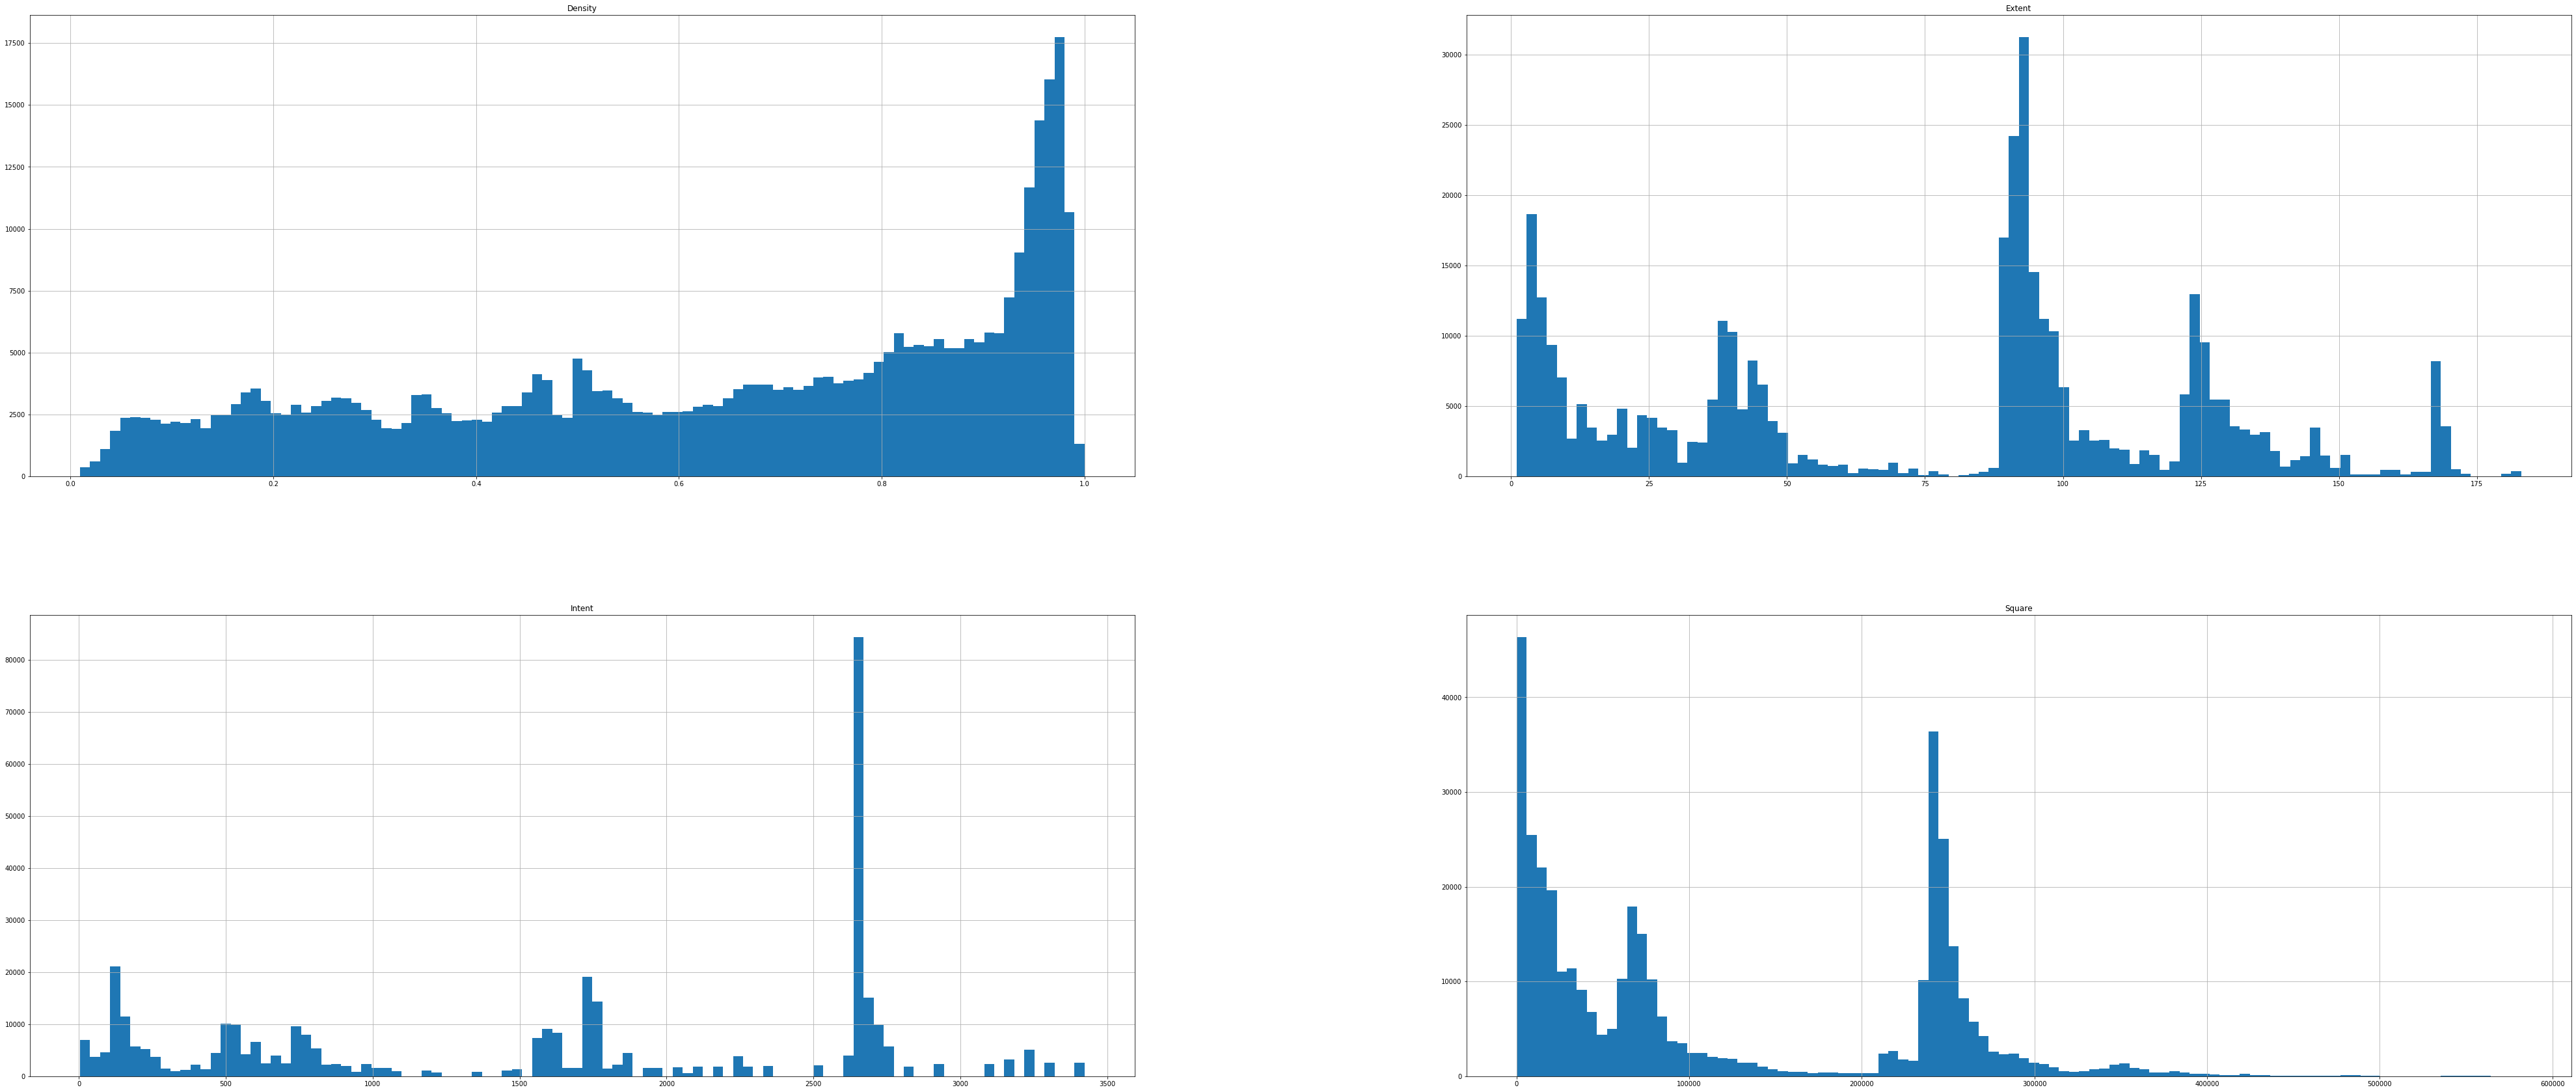

In [434]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (70,30))
ax = fig.gca()

df_Bs.hist(ax = ax, bins=100)

### Selection of dense and large biclusters

In [441]:
Sel=[]
for triple in range(len(Bicl_stat)):
    if Bicl_stat[triple][0]>=0.90 and Bicl_stat[triple][1]>=3 and Bicl_stat[triple][1]<=1500 and Bicl_stat[triple][2]>=3 and Bicl_stat[triple][2]<=80000:
        Sel.append(Bicl_stat[triple])

In [436]:
len(Sel)

98529

In [437]:
df_Sel=pd.DataFrame(Sel, columns =['Density', 'Extent', 'Intent'])

In [438]:
df_Sel['Square']=df_Sel['Extent']*df_Sel['Intent']

In [414]:
Sel

[[0.9835927375215471, 89, 2679],
 [0.9636940140859513, 91, 2679],
 [0.9637391350717218, 91, 2679],
 [0.9731201526274315, 90, 2679],
 [0.9740823690431754, 90, 2679],
 [0.9623116711582557, 91, 2679],
 [0.9432022059266216, 93, 2679],
 [0.9417572758251153, 93, 2679],
 [0.9221076206754287, 95, 2679],
 [0.9622665501724852, 91, 2679],
 [0.9421626589924823, 93, 2679],
 [0.9734478039069304, 90, 2679],
 [0.9740740740740741, 90, 2679],
 [0.9535680088287324, 92, 2679],
 [0.9636160778378023, 91, 2679],
 [0.9635914663910184, 91, 2679],
 [0.9533326841618385, 92, 2679],
 [0.9726722242959644, 90, 2679],
 [0.9517300420338543, 92, 2679],
 [0.9070356303128957, 97, 2679],
 [0.9525415064024538, 92, 2679],
 [0.9728795985234955, 90, 2679],
 [0.9531257607478456, 92, 2679],
 [0.9732528721330513, 90, 2679],
 [0.9641452239436562, 91, 2679],
 [0.9530649009202006, 92, 2679],
 [0.952314296379246, 92, 2679],
 [0.9729418107917548, 90, 2679],
 [0.9728339761934387, 90, 2679],
 [0.9519897106318062, 92, 2679],
 [0.9633904

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5db5202d0>,
      dtype=object)

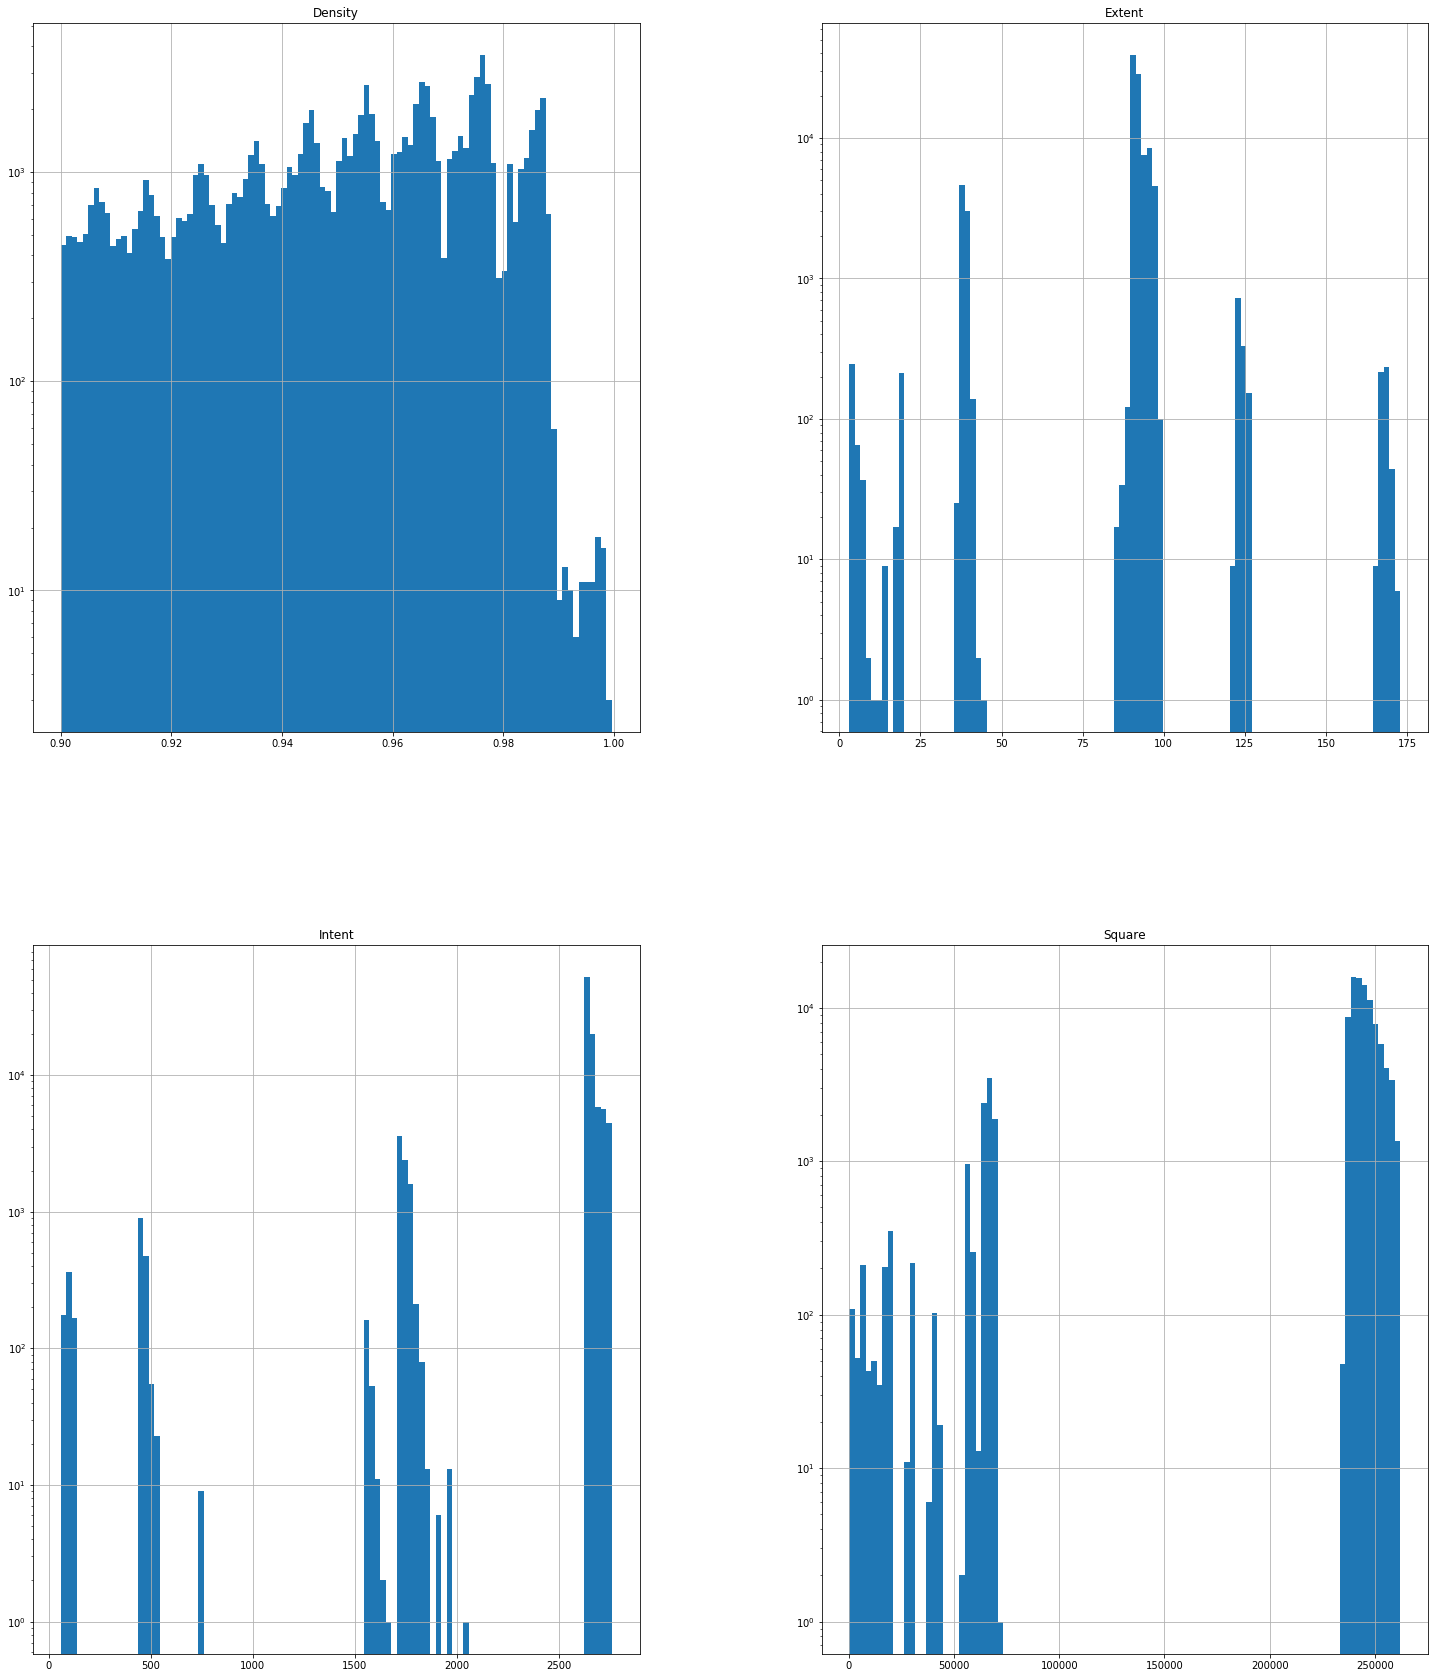

In [439]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (25,30))
ax = fig.gca()

df_Sel.hist(ax = ax, bins=100, log=True)

In [146]:
f = open("B.pkl","rb")
Bp=pickle.load(f)
f.close()

In [90]:
len(Bp)

383733

In [7]:
B=Bp

In [191]:
123

123

In [192]:
91

91

In [193]:
38

38

In [194]:
20

20

In [ ]:
165-170

In [232]:
def Selection(Bicl_stat, density_min, density_max, ext_min, ext_max, int_min, int_max):
    Sel=[]
    for triple in range(len(Bicl_stat)):
        if Bicl_stat[triple][0]>=density_min and Bicl_stat[triple][0]<=density_max and Bicl_stat[triple][1]>=ext_min and Bicl_stat[triple][1]<=ext_max and Bicl_stat[triple][2]>=int_min and Bicl_stat[triple][2]<=int_max:
            Sel.append(Bicl_stat[triple])
    return Sel            

In [300]:
pd.DataFrame(Selection(Bicl_stat,0.9408,1, 122, 122, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.940876,122.0,455.0
std,NaN,NaN,NaN
min,0.940876,122.0,455.0
25%,0.940876,122.0,455.0
50%,0.940876,122.0,455.0
75%,0.940876,122.0,455.0
max,0.940876,122.0,455.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc63765c390>,
      dtype=object)

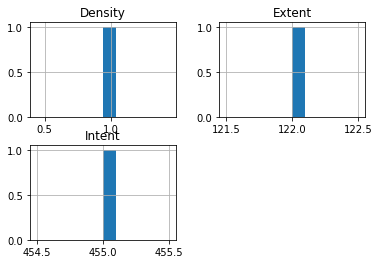

In [293]:
pd.DataFrame(Selection(Bicl_stat,0.9408,1, 122, 122, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [299]:
pd.DataFrame(Selection(Bicl_stat,0.999,1, 89, 89, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.999637,89.0,2634.0
std,NaN,NaN,NaN
min,0.999637,89.0,2634.0
25%,0.999637,89.0,2634.0
50%,0.999637,89.0,2634.0
75%,0.999637,89.0,2634.0
max,0.999637,89.0,2634.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc591d9df10>,
      dtype=object)

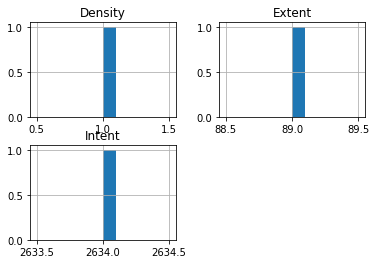

In [298]:
pd.DataFrame(Selection(Bicl_stat,0.999,1, 89, 89, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [304]:
pd.DataFrame(Selection(Bicl_stat,0.99,1, 36, 40, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.0000,1.0,1.0
mean,0.9906,36.0,1714.0
std,NaN,NaN,NaN
min,0.9906,36.0,1714.0
25%,0.9906,36.0,1714.0
50%,0.9906,36.0,1714.0
75%,0.9906,36.0,1714.0
max,0.9906,36.0,1714.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc575798750>,
      dtype=object)

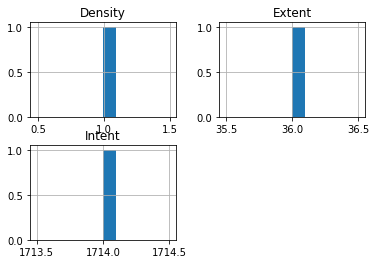

In [303]:
pd.DataFrame(Selection(Bicl_stat,0.99,1, 36, 40, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [309]:
pd.DataFrame(Selection(Bicl_stat,0.96,1, 18, 18, 3, 80000),columns =['Density', 'Extent', 'Intent']).describe()


,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.960016,18.0,1552.0
std,NaN,NaN,NaN
min,0.960016,18.0,1552.0
25%,0.960016,18.0,1552.0
50%,0.960016,18.0,1552.0
75%,0.960016,18.0,1552.0
max,0.960016,18.0,1552.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5dcf58b90>,
      dtype=object)

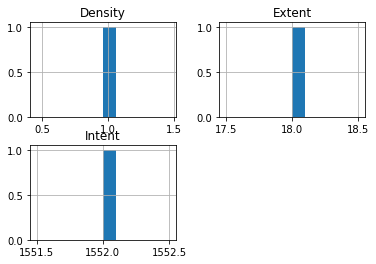

In [307]:
pd.DataFrame(Selection(Bicl_stat,0.96,1, 17, 22, 3, 80000),columns =['Density', 'Extent', 'Intent']).hist()

In [311]:
pd.DataFrame(Selection(Bicl_stat,0.954,1, 160, 175, 3, 80000),columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.954429,166.0,108.0
std,NaN,NaN,NaN
min,0.954429,166.0,108.0
25%,0.954429,166.0,108.0
50%,0.954429,166.0,108.0
75%,0.954429,166.0,108.0
max,0.954429,166.0,108.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc591ec2510>,
      dtype=object)

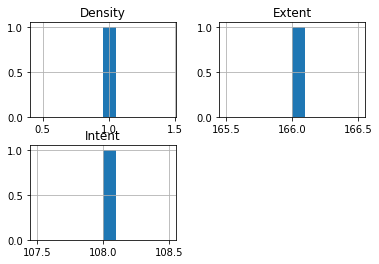

In [312]:
pd.DataFrame(Selection(Bicl_stat,0.954,1, 160, 175, 3, 80000),columns =['Density', 'Extent', 'Intent']).hist()

In [282]:
pd.DataFrame(Selection(Bicl_stat,0.92,1, 3, 1500, 520, 600),columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.921795,3.0,520.0
std,NaN,NaN,NaN
min,0.921795,3.0,520.0
25%,0.921795,3.0,520.0
50%,0.921795,3.0,520.0
75%,0.921795,3.0,520.0
max,0.921795,3.0,520.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc574c628d0>,
      dtype=object)

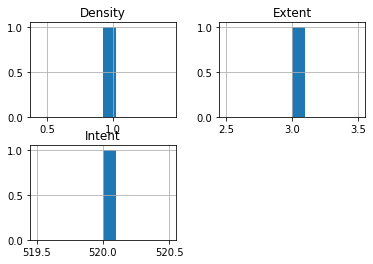

In [281]:
pd.DataFrame(Selection(Bicl_stat,0.92,1, 3, 1500, 520, 600),columns =['Density', 'Extent', 'Intent']).hist()

In [314]:
0.940876*122.0*455.0

52228.02676

In [315]:
122.0*455.0

55510.0

In [318]:
pd.DataFrame(Selection(Bicl_stat,0.90,1, 3, 1500, 2000, 2500),columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.900422,3.0,2052.0
std,NaN,NaN,NaN
min,0.900422,3.0,2052.0
25%,0.900422,3.0,2052.0
50%,0.900422,3.0,2052.0
75%,0.900422,3.0,2052.0
max,0.900422,3.0,2052.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5dd026850>,
      dtype=object)

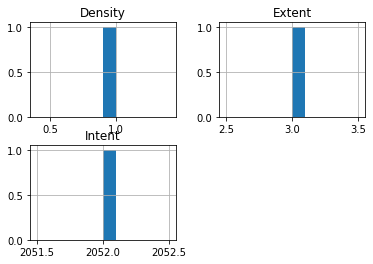

In [319]:
pd.DataFrame(Selection(Bicl_stat,0.9,1, 3, 1500, 2000, 2500),columns =['Density', 'Extent', 'Intent']).hist()

In [325]:
pd.DataFrame(Selection(Bicl_stat,0.9257,1, 14, 14, 3, 1000),columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.927514,14.0,743.0
std,NaN,NaN,NaN
min,0.927514,14.0,743.0
25%,0.927514,14.0,743.0
50%,0.927514,14.0,743.0
75%,0.927514,14.0,743.0
max,0.927514,14.0,743.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5759d0450>,
      dtype=object)

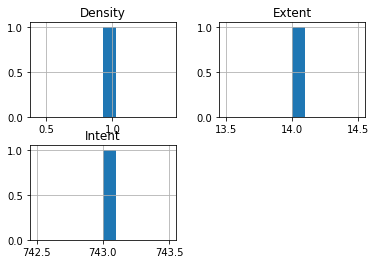

In [327]:
pd.DataFrame(Selection(Bicl_stat,0.9257,1, 14, 14, 3, 90000),columns =['Density', 'Extent', 'Intent']).hist()

In [332]:
pd.DataFrame(Selection(Bicl_stat,0.97,1, 3, 40, 3, 1000),columns =['Density', 'Extent', 'Intent']).describe()

,Density,Extent,Intent
count,1.000000,1.0,1.0
mean,0.975309,3.0,108.0
std,NaN,NaN,NaN
min,0.975309,3.0,108.0
25%,0.975309,3.0,108.0
50%,0.975309,3.0,108.0
75%,0.975309,3.0,108.0
max,0.975309,3.0,108.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5507bac50>,
      dtype=object)

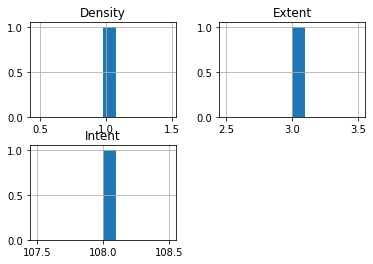

In [334]:
pd.DataFrame(Selection(Bicl_stat,0.97,1, 3, 40, 3, 1000),columns =['Density', 'Extent', 'Intent']).hist()

In [339]:
pd.DataFrame(Selection(Bicl_stat,0.91,1, 3, 40, 758, 758),columns =['Density', 'Extent', 'Intent']).describe()


,Density,Extent,Intent
count,2.000000,2.0,2.0
mean,0.910573,14.0,758.0
std,0.000000,0.0,0.0
min,0.910573,14.0,758.0
25%,0.910573,14.0,758.0
50%,0.910573,14.0,758.0
75%,0.910573,14.0,758.0
max,0.910573,14.0,758.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5920c7f90>,
      dtype=object)

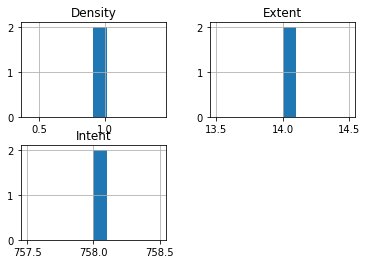

In [337]:
pd.DataFrame(Selection(Bicl_stat,0.9,1, 3, 40, 758, 758),columns =['Density', 'Extent', 'Intent']).hist()

### Incorporating RS

In [340]:
read_dictionary = np.load('snp_dict.npy', allow_pickle='TRUE').item()

In [341]:
read_dictionary

{0: 'rs12086311_0',
 1: 'rs4475691_A',
 2: 'rs9777703_G',
 3: 'rs3934834_A',
 4: 'rs3737728_A',
 5: 'rs6687776_A',
 6: 'rs4970405_G',
 7: 'rs4970362_A',
 8: 'rs9660710_A',
 9: 'rs9729550_C',
 10: 'rs3813199_A',
 11: 'rs715643_A',
 12: 'rs7524470_G',
 13: 'rs2649588_G',
 14: 'rs819980_G',
 15: 'rs6690515_A',
 16: 'rs6603793_A',
 17: 'rs7531583_A',
 18: 'rs742359_A',
 19: 'rs6681938_G',
 20: 'rs7525092_A',
 21: 'rs2803291_A',
 22: 'rs2254669_G',
 23: 'rs884080_A',
 24: 'rs908742_A',
 25: 'rs3107151_A',
 26: 'rs3128291_A',
 27: 'rs6665593_A',
 28: 'rs7512482_G',
 29: 'rs2460000_A',
 30: 'rs260513_A',
 31: 'rs7547453_A',
 32: 'rs11588312_A',
 33: 'rs7553178_G',
 34: 'rs10910047_A',
 35: 'rs2279702_A',
 36: 'rs2843157_A',
 37: 'rs903904_A',
 38: 'rs2843143_A',
 39: 'rs2055204_G',
 40: 'rs2840528_G',
 41: 'rs903914_A',
 42: 'rs7545940_G',
 43: 'rs2843160_C',
 44: 'rs2643901_A',
 45: 'rs4648633_G',
 46: 'rs3001336_G',
 47: 'rs2494428_G',
 48: 'rs6659405_A',
 49: 'rs11581548_A',
 50: 'rs109100

In [346]:
Bdl[0]

{(0, 0): (0.9835927375215471, 89, 2679)}

In [352]:
Bf={}
for idx in range(len(B)):
    #B[list(Bdl[idx].keys())[0]]
    Bf[list(Bdl[idx].keys())[0]]=B[list(Bdl[idx].keys())[0]],Bicl_stat[idx]



In [367]:
def FullSelection(Bdl,Bicl_stat, density_min, density_max, ext_min, ext_max, int_min, int_max):
    Bf={}
    for triple in range(len(Bicl_stat)):
        if Bicl_stat[triple][0]>=density_min and Bicl_stat[triple][0]<=density_max and Bicl_stat[triple][1]>=ext_min and Bicl_stat[triple][1]<=ext_max and Bicl_stat[triple][2]>=int_min and Bicl_stat[triple][2]<=int_max:
            Bf[list(Bdl[triple].keys())[0]]=B[list(Bdl[triple].keys())[0]],Bicl_stat[triple]
    return Bf  

In [369]:
ex=FullSelection(Bdl,Bicl_stat,0.91,1, 3, 40, 758, 758)

In [416]:
def EncodeSelection(Bf, enc_dict):
    B_enc={}
    for key in Bf.keys():
        enc=[]
        for rs_idx in Bf[key][0][1]:
            enc.append(enc_dict[rs_idx])
            B_enc[(key[0],enc_dict[key[1]])]= Bf[key][0][0],enc,Bf[key][1][0],Bf[key][1][1],Bf[key][1][2],Bf[key][1][1]*Bf[key][1][2]
    return B_enc       

In [417]:
ex1=EncodeSelection(ex, read_dictionary)

In [418]:
print(ex1)

{(1102, 'rs6704827_A'): ([1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114], ['rs10915587_G', 'rs284267_A', 'rs6656310_G', 'rs3124627_G', 'rs1055412_G', 'rs12119764_G', 'rs925826_A', 'rs11589265_A', 'rs6682357_A', 'rs1890020_G', 'rs696625_G', 'rs634378_C', 'rs4660531_A', 'rs10493096_A', 'rs1165284_A', 'rs2793673_A', 'rs10493294_A', 'rs12116810_C', 'rs6587971_G', 'rs834485_A', 'rs2807912_A', 'rs12028841_A', 'rs12127333_A', 'rs4593805_A', 'rs165277_C', 'rs17513917_A', 'rs2785597_C', 'rs17411335_C', 'rs1826316_G', 'rs1938344_A', 'rs12028453_A', 'rs10857934_C', 'rs577935_A', 'rs3936952_A', 'rs3007708_C', 'rs11581556_A', 'rs6681981_G', 'rs11810084_G', 'rs1412784_G', 'rs1327144_C', 'rs10798069_A', 'rs284113_A', 'rs339557_G', 'rs11579497_A', 'rs10922187_G', 'rs12119142_A', 'rs10920260_C', 'rs7366689_A', 'rs4844614_A', 'rs1875431_A', 'rs320471_G', 'rs10492958_G', 'rs10495060_G', 'rs6656145_C', 'rs1136448_G', 'rs10799322_A', 'rs9428368_C', 'rs12123434_A', 'rs10

In [392]:
f = open("B_full.pkl","wb")
pickle.dump(Bf,f)
f.close()

In [394]:
len(Bf)

383733

In [395]:
f = open("B_full.pkl","rb")
test=pickle.load(f)
f.close()

In [396]:
len(test)

383733

In [398]:
test[(0,0)]

([[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88],
  [0,
   1,
   2,
   15,
   18,
   22,
   48,
   49,
   53,
   55,
   56,
   57,
   58,
   75,
   108,
   111,
   122,
   140,
   235,
   257,
   278,
   337,
   339,
   344,
   368,
   382,
   383,
   384,
   447,
   450,
   456,
   527,
   553,
   558,
   667,
   685,
   687,
   700,
   701,
   711,
   839,
   909,
   915,
   944,
   945,
   976,
   1022,
   1057,
   1079,
   1085,